In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## Data preprocessing
### Load dataset

In [3]:
TRAIN_DATA_PATH = '../../dataset/train.csv'
TEST_DATA_PATH = '../../dataset/test.csv'
SAMPLE_SUB_PATH = '../../dataset/sample_submission.csv'
X_META_DATA_PATH = '../../dataset/meta/x_feature_info.csv'
Y_META_DATA_PATH = '../../dataset/meta/y_feature_info.csv'
SPEC_DATA_PATH = '../../dataset/meta/y_feature_spec_info.csv'


df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)
df_sample = pd.read_csv(SAMPLE_SUB_PATH)
df_x_meta = pd.read_csv(X_META_DATA_PATH)
df_y_meta = pd.read_csv(Y_META_DATA_PATH)
df_spec = pd.read_csv(SPEC_DATA_PATH)

NEW_DATA_PATH = '../../dataset/anomaly_cols_train.csv'
df_new = pd.read_csv(NEW_DATA_PATH)


## 각 label 별 분포 확인

In [12]:
Y_defeated_cols = [col for col in df_new.columns.to_list() if col.endswith('defeated')]
df_new_defated = df_new[Y_defeated_cols+['label']]
df_new_defated.head()

,Y_01_defeated,Y_02_defeated,Y_03_defeated,Y_04_defeated,Y_05_defeated,Y_06_defeated,Y_07_defeated,Y_08_defeated,Y_09_defeated,Y_10_defeated,Y_11_defeated,Y_12_defeated,Y_13_defeated,Y_14_defeated,label
0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


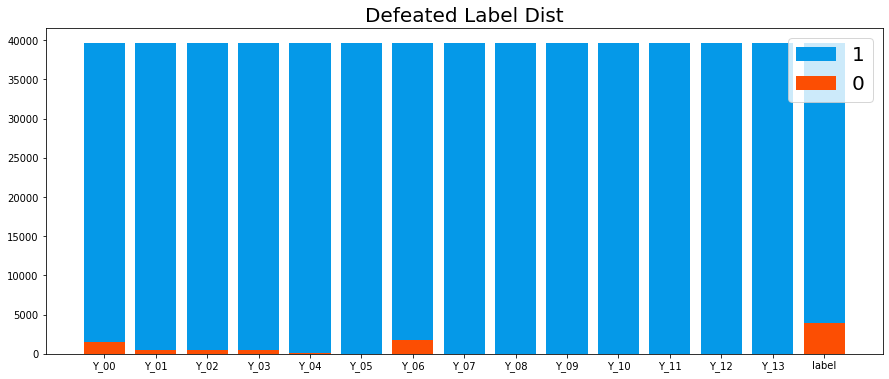

In [36]:
def bar_chart():
    labels = df_new_defated.columns.tolist()
    new_labels = [f'Y_{str(i).zfill(2)}' for i in range(14)]+['label']
    zeros, ones = [], []
    for label in labels:
        o, z = df_new_defated[label].value_counts()
        zeros.append(z)
        ones.append(o+z)

    plt.figure(figsize = (15, 6))
    plt.title("Defeated Label Dist", fontsize=20)
    plt.bar(new_labels, ones, label='1', color='#0599e8')
    plt.bar(new_labels, zeros, label='0', color='#fc4e03')
    plt.legend(fontsize=20)
    plt.show()

bar_chart()


In [39]:
x_groups = {
    'group1'    : [1, 2, 5, 6],                 # 단계별 누름량
    'group2'    : [3, 7, 10, 8, 11, 9],         # 방열재료 n의 무게, 면적
    'group3'    : [12, 13, 14, 15, 16, 17, 18], # 12: 커넥터 위치, 13: 안테나 패드위치 차이, 나머지 안테나 패드 위치
    'group4'    : [19, 20, 21, 22],             # n(1~4) 스크류 삽입 깊이   장비1
    'group5'    : [12, 24, 25, 26, 27, 28, 29], # 12: 커넥터 위치, n(1~6) 핀 치수  
    'group6'    : [30, 31, 32, 33],             # n(1~4) 스크류 삽입 깊이   장비2
    'group7'    : [34, 35, 36, 37],             # n(1~4) 스크류 체결 분당 회전수
    'group8'    : [38, 39, 40],                 # 하우징 PCB 안착부 치수
    'group9'    : [41, 42, 43, 44, 45],         # n(1~4) 안테나 레이돔 치수, 마지막은 레이돔 기울기
    'group10'   : [49, 50, 51, 52, 53, 54, 55, 56]     # 실란트 본드, cal 투입 전 대기시간, RF1~7 smt 납 양
}   

y_groups = {
    'group1'    : [1, 5, 7, 11],        # 안테나 Gain 평균 각도 1~4
    'group2'    : [2, 3],               # 안테나 Gain 편차 1~2
    'group3'    : [4, 6,  8, 9, 10, 12, 13, 14]     # 평균 신호대, 신호대 잡음비 각도 1~7
}   

In [76]:
def view_x_y_defeated_dists(df, x_group_num, y_group_num):
    x_group_cols = [f'X_{str(x).zfill(2)}' for x in x_group_num]
    y_group_cols = [f'Y_{str(x).zfill(2)}_defeated' for x in y_group_num]

    df_x_group = df[x_group_cols]
    df_y_group = df[y_group_cols]

    for y_label in y_group_cols:
        defated_df = df_x_group[df_y_group[y_label]==0]
        not_defated_df = df_x_group[df_y_group[y_label]==1]
        for x_label in x_group_cols:
            print(f"# ==== X : {x_label}, Y : {y_label} ==== #")
            d_mean = defated_df[x_label].describe()['mean']
            d_std = defated_df[x_label].describe()['std']

            nd_mean = not_defated_df[x_label].describe()['mean']
            nd_std = not_defated_df[x_label].describe()['std']

            print(f"\t Mean : [{d_mean}, {nd_mean}] \t Std : [{d_std}, {nd_std}]")
    # plt.hist()


In [79]:
def view_x_yall_defeated_dists(df, x_group_num):
    x_group_cols = [f'X_{str(x).zfill(2)}' for x in x_group_num]
    y_group_cols = ['label']

    df_x_group = df[x_group_cols]
    df_y_group = df[y_group_cols]

    for y_label in y_group_cols:
        defated_df = df_x_group[df_y_group[y_label]==0]
        not_defated_df = df_x_group[df_y_group[y_label]==1]
        for x_label in x_group_cols:
            print(f"# ==== X : {x_label}, Y : {y_label} ==== #")
            d_mean = defated_df[x_label].describe()['mean']
            d_std = defated_df[x_label].describe()['std']

            nd_mean = not_defated_df[x_label].describe()['mean']
            nd_std = not_defated_df[x_label].describe()['std']

            print(f"\t Mean : [{d_mean}, {nd_mean}] \t Std : [{d_std}, {nd_std}]")
    # plt.hist()


In [85]:
for i in range(10):
    view_x_yall_defeated_dists(df_new, x_groups[f'group{i+1}'])

# ==== X : X_01, Y : label ==== #
	 Mean : [68.26816441153943, 68.42783006444382] 	 Std : [2.5377904393638175, 2.6681971884583393]
# ==== X : X_02, Y : label ==== #
	 Mean : [103.32017207046205, 103.3201656766601] 	 Std : [0.00037748986435526754, 0.0003717953436263557]
# ==== X : X_05, Y : label ==== #
	 Mean : [102.29064794485575, 102.34231213224993] 	 Std : [0.5294185208833654, 0.5501588021987067]
# ==== X : X_06, Y : label ==== #
	 Mean : [70.57333163135053, 70.59983213785374] 	 Std : [2.2015557027500465, 2.2661379807363127]
# ==== X : X_03, Y : label ==== #
	 Mean : [68.65659688537144, 68.84498458952086] 	 Std : [4.815969411546599, 5.186361040274525]
# ==== X : X_07, Y : label ==== #
	 Mean : [29.364084758743935, 29.412253572429254] 	 Std : [7.749676068947067, 7.2917287146382135]
# ==== X : X_10, Y : label ==== #
	 Mean : [0.004033699259637478, 0.0022751471000280192] 	 Std : [0.11301453388922415, 0.08279275518361184]
# ==== X : X_08, Y : label ==== #
	 Mean : [160.6373219300485, 16

In [78]:
# view_x_y_defeated_dists(df_new, x_groups['group1'], y_groups['group1'])
view_x_y_defeated_dists(df_new, x_groups['group2'], y_groups['group1'])

# ==== X : X_03, Y : Y_01_defeated ==== #
	 Mean : [69.09784552845527, 68.81584458839264] 	 Std : [4.697045991899661, 5.167712631724681]
# ==== X : X_07, Y : Y_01_defeated ==== #
	 Mean : [29.274390243902438, 29.412641944874252] 	 Std : [8.127048012080236, 7.306025372350097]
# ==== X : X_10, Y : Y_01_defeated ==== #
	 Mean : [0.0020325203252032522, 0.0024651858068238442] 	 Std : [0.07808688094430304, 0.0865560843869736]
# ==== X : X_08, Y : Y_01_defeated ==== #
	 Mean : [160.12841463414634, 164.6165760142666] 	 Std : [203.24500922125816, 221.04058213457054]
# ==== X : X_11, Y : Y_01_defeated ==== #
	 Mean : [0.0004065040650406504, 0.000364532794838845] 	 Std : [0.015617376188860606, 0.014085398556965617]
# ==== X : X_09, Y : Y_01_defeated ==== #
	 Mean : [222.5741598915989, 225.50675618263358] 	 Std : [66.5855373112101, 66.73896308444564]
# ==== X : X_03, Y : Y_05_defeated ==== #
	 Mean : [68.9831868131868, 68.82599250936329] 	 Std : [4.379959634294179, 5.152851128817728]
# ==== X : X_